In [1]:
import pandas as pd
import os
import shutil
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [3]:
df = pd.read_excel("ODIR-5K/data.xlsx")

In [4]:
df.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
5,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
6,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1
7,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
8,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
9,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1


In [5]:
src_dir = 'ODIR-5K/Training Images/'
target_dir = 'labeled_images/'

if not os.path.exists(target_dir):
    os.mkdir(target_dir)

## Function to map the label to the respected file and copy it to a new directory

In [6]:
def copy_to_dir_right_eye(word, directory) : 
    for i in range(len(df)):
        # Get the label and file path from the current row
        label = df.iloc[i]['Right-Diagnostic Keywords']
        file_path = df.iloc[i]['Right-Fundus']
        # Check if the label matches the label to move
        if word in label:
            # Build the target subdirectory path
            target_file_path = os.path.join(directory, os.path.basename(file_path))
            # Build the source file path
            src_file_path = os.path.join(src_dir, file_path)
            # Move the file to the target directory
            shutil.copy(src_file_path, target_file_path)
            # Print progress
            # print(f"Moved {file_path} to {target_file_path}")

In [7]:
def copy_to_dir_left_eye(word, directory) : 
    for i in range(len(df)):
        # Get the label and file path from the current row
        label = df.iloc[i]['Left-Diagnostic Keywords']
        file_path = df.iloc[i]['Left-Fundus']
        # Check if the label matches the label to move
        if word in label:
            # Build the target subdirectory path
            target_file_path = os.path.join(directory, os.path.basename(file_path))
            # Build the source file path
            src_file_path = os.path.join(src_dir, file_path)
            # Move the file to the target directory
            shutil.copy(src_file_path, target_file_path)
            # Print progress
            # print(f"Moved {file_path} to {target_file_path}")

In [8]:
cataract_label = 'cataract'
cataract_dir = os.path.join(target_dir, 'cataract')
if not os.path.exists(cataract_dir):
    os.mkdir(cataract_dir)

copy_to_dir_left_eye(cataract_label, cataract_dir)
copy_to_dir_right_eye(cataract_label, cataract_dir)

In [9]:
normal_label = 'normal fundus'
normal_dir = os.path.join(target_dir, 'normal')
if not os.path.exists(normal_dir):
    os.mkdir(normal_dir)

copy_to_dir_left_eye(normal_label, normal_dir)
copy_to_dir_right_eye(normal_label, normal_dir)

# Preprocessing

### Plot images from directory

In [10]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

def plot(directory, title) : 
    # get the list of image file names in the directory
    image_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]
    # randomly select 36 images
    random_images = random.sample(image_files, 16)
    # create figure with 6x6 grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    # loop through subplots and display each image with RGB colors
    for i in range(4):
        for j in range(4):
            # open image
            img = Image.open(random_images[i*4+j])
            # convert to RGB if necessary (without this piece of code the images will plot with a yellow tint)
            if img.mode != 'RGB':
                img = img.convert('RGB')

            # display image in subplot
            axs[i, j].imshow(img)
            axs[i, j].set_title(title)
            axs[i, j].axis('off')

    # show plot
    plt.show()

### Plot raw data images

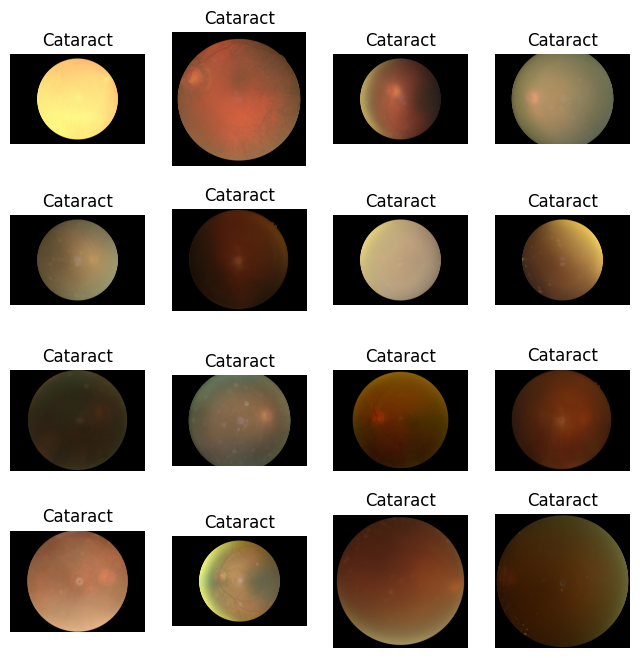

In [11]:
cat = "labeled_images/cataract/"
nor = "labeled_images/normal/"

plot(cat, "Cataract")

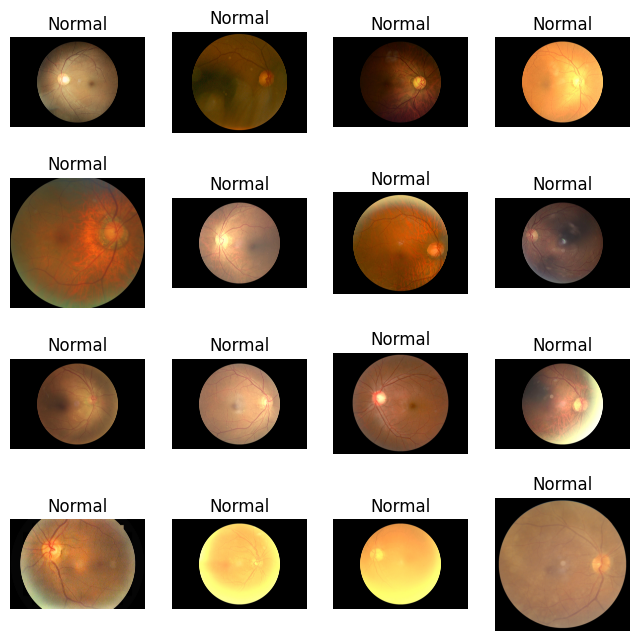

In [12]:
plot(nor, "Normal")

### Cropping and resizing using multiprocessing

In [13]:
import time
import multiprocessing
from multiprocessing import Pool, cpu_count 
import os
from func import thresh_crop_image, resize_image, remove_background

In [14]:
# WE CHECK FOR THE NUMBER OF PROCESSORS AVAILABLE IN THIS DEVICE 
cpu_no = multiprocessing.cpu_count()
print(f"Number of Available Processors is {cpu_no}")

Number of Available Processors is 16


In [15]:
if __name__ == "__main__":

    SOURCE_DIRECTORY = cataract_dir
    directory_list = os.listdir(SOURCE_DIRECTORY)

    filelist = []
    for source_file in directory_list:
        source_path = os.path.join(SOURCE_DIRECTORY, source_file)
        if os.path.isfile(source_path):
            filelist.append(source_path)

    with Pool(16) as pool:  # 16 is number of processes we want to use
        for result in pool.imap_unordered(thresh_crop_image, filelist):
            print(result)

    with Pool(16) as pool:  # 16 is number of processes we want to use
        for result in pool.imap_unordered(resize_image, filelist):
            print(result)

1101_right.jpg cropped.
103_left.jpg cropped.
0_left.jpg cropped.
1115_left.jpg cropped.
1083_left.jpg cropped.
1126_right.jpg cropped.
1144_left.jpg cropped.
1102_right.jpg cropped.
1102_left.jpg cropped.
119_left.jpg cropped.
1144_right.jpg cropped.
1084_right.jpg cropped.
1167_right.jpg cropped.
1415_left.jpg cropped.
112_right.jpg cropped.
1415_right.jpg cropped.
1460_right.jpg cropped.
1062_right.jpg cropped.
1456_right.jpg cropped.
1456_left.jpg cropped.
1483_right.jpg cropped.
1483_left.jpg cropped.
188_right.jpg cropped.
1164_left.jpg cropped.
1987_left.jpg cropped.
1484_left.jpg cropped.
1484_right.jpg cropped.
1435_left.jpg cropped.
1452_left.jpg cropped.
1468_left.jpg cropped.
2052_left.jpg cropped.
1994_left.jpg cropped.
1490_right.jpg cropped.
1444_left.jpg cropped.
2052_right.jpg cropped.
1454_right.jpg cropped.
1285_left.jpg cropped.
2095_right.jpg cropped.
2100_right.jpg cropped.
2099_left.jpg cropped.
2097_right.jpg cropped.
2096_right.jpg cropped.
2102_left.jpg croppe

2123_left.jpg resized.
2118_right.jpg resized.
2120_right.jpg resized.
2116_right.jpg resized.
2124_left.jpg resized.
2122_left.jpg resized.
2122_right.jpg resized.
2115_right.jpg resized.
2125_left.jpg resized.
2116_left.jpg resized.
2126_left.jpg resized.
2121_left.jpg resized.
2126_right.jpg resized.
2127_left.jpg resized.
2127_right.jpg resized.
2128_right.jpg resized.
2132_left.jpg resized.
2133_right.jpg resized.
2129_left.jpg resized.
2129_right.jpg resized.
2130_left.jpg resized.
2128_left.jpg resized.
2130_right.jpg resized.
2134_left.jpg resized.
2134_right.jpg resized.
2133_left.jpg resized.
2135_left.jpg resized.
2135_right.jpg resized.
2136_left.jpg resized.
2137_left.jpg resized.
2138_left.jpg resized.
2143_right.jpg resized.
2144_left.jpg resized.
2138_right.jpg resized.
2142_right.jpg resized.
2140_right.jpg resized.
2144_right.jpg resized.
2139_right.jpg resized.
2140_left.jpg resized.
2142_left.jpg resized.
2137_right.jpg resized.
2145_left.jpg resized.
2146_left.jpg 

In [16]:
SOURCE_DIRECTORY = normal_dir
directory_list = os.listdir(SOURCE_DIRECTORY)

filelist = []
for source_file in directory_list:
    source_path = os.path.join(SOURCE_DIRECTORY, source_file)
    if os.path.isfile(source_path):
        filelist.append(source_path)

with Pool(16) as pool:  # 16 is number of processes we want to use
    for result in pool.imap_unordered(thresh_crop_image, filelist):
        print(result)

with Pool(16) as pool:  # 16 is number of processes we want to use
    for result in pool.imap_unordered(resize_image, filelist):
        print(result)

1017_left.jpg cropped.
1005_right.jpg cropped.
1017_right.jpg cropped.
0_right.jpg cropped.
1018_right.jpg cropped.
1008_left.jpg cropped.
1010_left.jpg cropped.
1014_right.jpg cropped.
1019_right.jpg cropped.
1011_left.jpg cropped.
1016_left.jpg cropped.
1028_right.jpg cropped.
1023_left.jpg cropped.
1035_left.jpg cropped.
1021_left.jpg cropped.
1013_left.jpg cropped.
1036_left.jpg cropped.
1034_left.jpg cropped.
1033_left.jpg cropped.
1034_right.jpg cropped.
1032_left.jpg cropped.
1006_left.jpg cropped.
1038_left.jpg cropped.
100_right.jpg cropped.
103_right.jpg cropped.
1053_left.jpg cropped.
1054_right.jpg cropped.
1054_left.jpg cropped.
1059_right.jpg cropped.
105_right.jpg cropped.
1040_right.jpg cropped.
1066_right.jpg cropped.
1072_left.jpg cropped.
1058_left.jpg cropped.
1086_left.jpg cropped.
1072_right.jpg cropped.
1061_right.jpg cropped.
1039_right.jpg cropped.
1080_right.jpg cropped.
1041_left.jpg cropped.
107_left.jpg cropped.
1074_right.jpg cropped.
1077_left.jpg cropped

2367_right.jpg cropped.
2369_right.jpg cropped.
2368_right.jpg cropped.
2368_left.jpg cropped.
2372_left.jpg cropped.
2371_left.jpg cropped.
2371_right.jpg cropped.
2372_right.jpg cropped.
2365_left.jpg cropped.
2375_left.jpg cropped.
2374_left.jpg cropped.
236_right.jpg cropped.
2373_left.jpg cropped.
2373_right.jpg cropped.
2365_right.jpg cropped.
2375_right.jpg cropped.
2374_right.jpg cropped.
2379_left.jpg cropped.
2378_left.jpg cropped.
2379_right.jpg cropped.
2378_right.jpg cropped.
237_left.jpg cropped.
2381_right.jpg cropped.
2381_left.jpg cropped.
2383_left.jpg cropped.
2382_left.jpg cropped.
2382_right.jpg cropped.
2383_right.jpg cropped.
2376_right.jpg cropped.
2384_right.jpg cropped.
2384_left.jpg cropped.
2385_left.jpg cropped.
2376_left.jpg cropped.
2385_right.jpg cropped.
2380_right.jpg cropped.
2380_left.jpg cropped.
2377_left.jpg cropped.
2388_left.jpg cropped.
2377_right.jpg cropped.
2389_left.jpg cropped.
2388_right.jpg cropped.
2389_right.jpg cropped.
2387_left.jpg 

2544_left.jpg cropped.
2544_right.jpg cropped.
2550_right.jpg cropped.
2545_right.jpg cropped.
2550_left.jpg cropped.
2549_left.jpg cropped.
2545_left.jpg cropped.
2547_left.jpg cropped.
2547_right.jpg cropped.
2549_right.jpg cropped.
2548_left.jpg cropped.
2548_right.jpg cropped.
2551_left.jpg cropped.
2551_right.jpg cropped.
2552_left.jpg cropped.
2546_left.jpg cropped.
2546_right.jpg cropped.
2552_right.jpg cropped.
2556_left.jpg cropped.
2558_right.jpg cropped.
2554_right.jpg cropped.
2554_left.jpg cropped.
2555_right.jpg cropped.
2555_left.jpg cropped.
2558_left.jpg cropped.
2556_right.jpg cropped.
2553_right.jpg cropped.
2553_left.jpg cropped.
255_left.jpg cropped.
2557_right.jpg cropped.
2557_left.jpg cropped.
2563_right.jpg cropped.
2563_left.jpg cropped.
2562_left.jpg cropped.
2562_right.jpg cropped.
2559_left.jpg cropped.
2559_right.jpg cropped.
2564_left.jpg cropped.
2564_right.jpg cropped.
2561_right.jpg cropped.
2561_left.jpg cropped.
2566_left.jpg cropped.
2566_right.jpg 

2713_left.jpg cropped.
2713_right.jpg cropped.
2720_right.jpg cropped.
2720_left.jpg cropped.
2722_left.jpg cropped.
2723_left.jpg cropped.
2723_right.jpg cropped.
2714_left.jpg cropped.
2722_right.jpg cropped.
2714_right.jpg cropped.
2726_right.jpg cropped.
2726_left.jpg cropped.
2727_left.jpg cropped.
2727_right.jpg cropped.
2728_right.jpg cropped.
2728_left.jpg cropped.
2715_left.jpg cropped.
2729_right.jpg cropped.
2729_left.jpg cropped.
2730_right.jpg cropped.
2725_right.jpg cropped.
2715_right.jpg cropped.
2731_left.jpg cropped.
2730_left.jpg cropped.
2731_right.jpg cropped.
2725_left.jpg cropped.
2724_right.jpg cropped.
2734_right.jpg cropped.
2734_left.jpg cropped.
2724_left.jpg cropped.
2733_left.jpg cropped.
2733_right.jpg cropped.
2736_left.jpg cropped.
2721_left.jpg cropped.
2738_right.jpg cropped.
2738_left.jpg cropped.
2736_right.jpg cropped.
2721_right.jpg cropped.
2739_left.jpg cropped.
2739_right.jpg cropped.
2737_left.jpg cropped.
2737_right.jpg cropped.
2741_right.jp

2884_left.jpg cropped.
2889_left.jpg cropped.
2889_right.jpg cropped.
2890_left.jpg cropped.
2890_right.jpg cropped.
2891_right.jpg cropped.
2884_right.jpg cropped.
2891_left.jpg cropped.
2894_left.jpg cropped.
2894_right.jpg cropped.
2892_left.jpg cropped.
2892_right.jpg cropped.
2896_left.jpg cropped.
2898_right.jpg cropped.
2898_left.jpg cropped.
2896_right.jpg cropped.
2895_left.jpg cropped.
2893_right.jpg cropped.
2895_right.jpg cropped.
2893_left.jpg cropped.
2900_left.jpg cropped.
2899_left.jpg cropped.
2900_right.jpg cropped.
2899_right.jpg cropped.
2901_left.jpg cropped.
2901_right.jpg cropped.
2908_left.jpg cropped.
2902_left.jpg cropped.
2908_right.jpg cropped.
2904_left.jpg cropped.
2897_left.jpg cropped.
2902_right.jpg cropped.
2904_right.jpg cropped.
2897_right.jpg cropped.
2907_right.jpg cropped.
2907_left.jpg cropped.
2910_left.jpg cropped.
2903_left.jpg cropped.
2910_right.jpg cropped.
2903_right.jpg cropped.
290_left.jpg cropped.
2909_left.jpg cropped.
2909_right.jpg 

3063_left.jpg cropped.
3065_left.jpg cropped.
3064_right.jpg cropped.
3058_left.jpg cropped.
3063_right.jpg cropped.
3064_left.jpg cropped.
3065_right.jpg cropped.
3058_right.jpg cropped.
3062_right.jpg cropped.
3062_left.jpg cropped.
3051_right.jpg cropped.
3051_left.jpg cropped.
3059_left.jpg cropped.
3066_left.jpg cropped.
3059_right.jpg cropped.
3066_right.jpg cropped.
3067_left.jpg cropped.
3068_left.jpg cropped.
3068_right.jpg cropped.
3067_right.jpg cropped.
306_left.jpg cropped.
3070_right.jpg cropped.
3072_left.jpg cropped.
3070_left.jpg cropped.
3074_left.jpg cropped.
3072_right.jpg cropped.
3073_right.jpg cropped.
3074_right.jpg cropped.
3073_left.jpg cropped.
3075_right.jpg cropped.
3075_left.jpg cropped.
3069_right.jpg cropped.
3069_left.jpg cropped.
3071_left.jpg cropped.
3071_right.jpg cropped.
3078_left.jpg cropped.
3080_left.jpg cropped.
3080_right.jpg cropped.
3078_right.jpg cropped.
3081_left.jpg cropped.
3081_right.jpg cropped.
307_left.jpg cropped.
3082_right.jpg c

3228_right.jpg cropped.
3236_right.jpg cropped.
3236_left.jpg cropped.
3238_right.jpg cropped.
3238_left.jpg cropped.
3234_left.jpg cropped.
3230_left.jpg cropped.
3234_right.jpg cropped.
3230_right.jpg cropped.
3235_left.jpg cropped.
3235_right.jpg cropped.
3237_left.jpg cropped.
3237_right.jpg cropped.
3239_left.jpg cropped.
3233_left.jpg cropped.
3233_right.jpg cropped.
3239_right.jpg cropped.
3241_right.jpg cropped.
3241_left.jpg cropped.
3243_left.jpg cropped.
3247_left.jpg cropped.
3243_right.jpg cropped.
3247_right.jpg cropped.
3242_left.jpg cropped.
3245_right.jpg cropped.
3245_left.jpg cropped.
3242_right.jpg cropped.
3244_left.jpg cropped.
3244_right.jpg cropped.
3240_right.jpg cropped.
3240_left.jpg cropped.
3246_left.jpg cropped.
3246_right.jpg cropped.
3248_left.jpg cropped.
3248_right.jpg cropped.
3252_left.jpg cropped.
3252_right.jpg cropped.
3250_left.jpg cropped.
3250_right.jpg cropped.
3251_left.jpg cropped.
3249_left.jpg cropped.
3249_right.jpg cropped.
3251_right.jp

3404_right.jpg cropped.
3402_right.jpg cropped.
3405_left.jpg cropped.
3405_right.jpg cropped.
3403_left.jpg cropped.
3403_right.jpg cropped.
3404_left.jpg cropped.
3407_left.jpg cropped.
3407_right.jpg cropped.
3396_left.jpg cropped.
3396_right.jpg cropped.
3410_right.jpg cropped.
3410_left.jpg cropped.
340_right.jpg cropped.
3406_right.jpg cropped.
3406_left.jpg cropped.
3409_right.jpg cropped.
3409_left.jpg cropped.
3416_right.jpg cropped.
3416_left.jpg cropped.
3415_left.jpg cropped.
3418_left.jpg cropped.
3414_right.jpg cropped.
3415_right.jpg cropped.
3413_right.jpg cropped.
3414_left.jpg cropped.
3418_right.jpg cropped.
3413_left.jpg cropped.
3411_right.jpg cropped.
3411_left.jpg cropped.
3422_left.jpg cropped.
3419_left.jpg cropped.
3422_right.jpg cropped.
3419_right.jpg cropped.
3420_right.jpg cropped.
3412_left.jpg cropped.
3417_right.jpg cropped.
3420_left.jpg cropped.
3412_right.jpg cropped.
3423_right.jpg cropped.
3417_left.jpg cropped.
3423_left.jpg cropped.
3425_left.jpg

472_right.jpg cropped.
483_right.jpg cropped.
468_left.jpg cropped.
476_left.jpg cropped.
4618_left.jpg cropped.
478_right.jpg cropped.
482_right.jpg cropped.
481_right.jpg cropped.
496_left.jpg cropped.
49_right.jpg cropped.
488_left.jpg cropped.
501_right.jpg cropped.
521_left.jpg cropped.
503_right.jpg cropped.
500_right.jpg cropped.
509_left.jpg cropped.
513_left.jpg cropped.
51_left.jpg cropped.
515_left.jpg cropped.
524_left.jpg cropped.
512_right.jpg cropped.
522_left.jpg cropped.
523_left.jpg cropped.
508_right.jpg cropped.
528_left.jpg cropped.
544_left.jpg cropped.
530_right.jpg cropped.
486_right.jpg cropped.
530_left.jpg cropped.
534_right.jpg cropped.
548_right.jpg cropped.
536_left.jpg cropped.
52_left.jpg cropped.
549_right.jpg cropped.
54_left.jpg cropped.
511_left.jpg cropped.
527_right.jpg cropped.
529_left.jpg cropped.
540_left.jpg cropped.
470_right.jpg cropped.
545_right.jpg cropped.
552_right.jpg cropped.
559_left.jpg cropped.
554_left.jpg cropped.
570_left.jpg cr

1465_left.jpg resized.
1428_right.jpg resized.
1460_left.jpg resized.
1479_right.jpg resized.
1441_right.jpg resized.
1450_right.jpg resized.
146_left.jpg resized.
1455_right.jpg resized.
1453_left.jpg resized.
1452_right.jpg resized.
1478_right.jpg resized.
1475_right.jpg resized.
1468_right.jpg resized.
1435_right.jpg resized.
1486_right.jpg resized.
1444_right.jpg resized.
1476_left.jpg resized.
150_right.jpg resized.
1490_left.jpg resized.
147_left.jpg resized.
1489_right.jpg resized.
1485_left.jpg resized.
149_left.jpg resized.
1491_right.jpg resized.
14_left.jpg resized.
1498_right.jpg resized.
1503_left.jpg resized.
1507_left.jpg resized.
1514_right.jpg resized.
1513_left.jpg resized.
1541_right.jpg resized.
151_left.jpg resized.
1556_right.jpg resized.
1519_left.jpg resized.
1493_right.jpg resized.
1510_left.jpg resized.
1494_right.jpg resized.
165_right.jpg resized.
159_right.jpg resized.
1610_right.jpg resized.
1611_right.jpg resized.
1619_left.jpg resized.
1590_left.jpg resi

2457_right.jpg resized.
2457_left.jpg resized.
2454_left.jpg resized.
2456_left.jpg resized.
2445_right.jpg resized.
2458_right.jpg resized.
2456_right.jpg resized.
2448_left.jpg resized.
2445_left.jpg resized.
2454_right.jpg resized.
2458_left.jpg resized.
2448_right.jpg resized.
244_right.jpg resized.
2459_right.jpg resized.
2459_left.jpg resized.
245_left.jpg resized.
2461_left.jpg resized.
2461_right.jpg resized.
2462_left.jpg resized.
2462_right.jpg resized.
2467_left.jpg resized.
2467_right.jpg resized.
2466_left.jpg resized.
2460_right.jpg resized.
2466_right.jpg resized.
2468_left.jpg resized.
2460_left.jpg resized.
2465_left.jpg resized.
2465_right.jpg resized.
2468_right.jpg resized.
2463_right.jpg resized.
2464_right.jpg resized.
2464_left.jpg resized.
2463_left.jpg resized.
2473_left.jpg resized.
2472_right.jpg resized.
2472_left.jpg resized.
2473_right.jpg resized.
2476_left.jpg resized.
2476_right.jpg resized.
2469_left.jpg resized.
2470_right.jpg resized.
2469_right.jpg 

2646_left.jpg resized.
2648_left.jpg resized.
2648_right.jpg resized.
2649_left.jpg resized.
2652_left.jpg resized.
2652_right.jpg resized.
2650_left.jpg resized.
2649_right.jpg resized.
2650_right.jpg resized.
2653_right.jpg resized.
2655_left.jpg resized.
2653_left.jpg resized.
2655_right.jpg resized.
2657_left.jpg resized.
2651_left.jpg resized.
2651_right.jpg resized.
2659_left.jpg resized.
2657_right.jpg resized.
2659_right.jpg resized.
2656_left.jpg resized.
2661_left.jpg resized.
2654_right.jpg resized.
2656_right.jpg resized.
2658_right.jpg resized.
2658_left.jpg resized.
2660_left.jpg resized.
2661_right.jpg resized.
2654_left.jpg resized.
2660_right.jpg resized.
2663_right.jpg resized.
2663_left.jpg resized.
2664_left.jpg resized.
2664_right.jpg resized.
2665_right.jpg resized.
2665_left.jpg resized.
2672_left.jpg resized.
2666_left.jpg resized.
2666_right.jpg resized.
2662_left.jpg resized.
2667_right.jpg resized.
2672_right.jpg resized.
2667_left.jpg resized.
2668_left.jpg 

2839_right.jpg resized.
2840_left.jpg resized.
2839_left.jpg resized.
2837_left.jpg resized.
2838_left.jpg resized.
2838_right.jpg resized.
2837_right.jpg resized.
2840_right.jpg resized.
2841_left.jpg resized.
2841_right.jpg resized.
2842_right.jpg resized.
2842_left.jpg resized.
2845_left.jpg resized.
2843_left.jpg resized.
2847_left.jpg resized.
2847_right.jpg resized.
2845_right.jpg resized.
2843_right.jpg resized.
2844_left.jpg resized.
2846_left.jpg resized.
2844_right.jpg resized.
2846_right.jpg resized.
2850_right.jpg resized.
2850_left.jpg resized.
2849_right.jpg resized.
2849_left.jpg resized.
2848_right.jpg resized.
2848_left.jpg resized.
2851_left.jpg resized.
2852_right.jpg resized.
2851_right.jpg resized.
2852_left.jpg resized.
2856_left.jpg resized.
2855_left.jpg resized.
2855_right.jpg resized.
2854_left.jpg resized.
2856_right.jpg resized.
2854_right.jpg resized.
2858_left.jpg resized.
2858_right.jpg resized.
2861_right.jpg resized.
2861_left.jpg resized.
2859_left.jpg

3034_right.jpg resized.
3031_left.jpg resized.
3031_right.jpg resized.
3038_right.jpg resized.
3035_left.jpg resized.
3037_right.jpg resized.
3038_left.jpg resized.
3035_right.jpg resized.
3037_left.jpg resized.
303_left.jpg resized.
3040_left.jpg resized.
3042_left.jpg resized.
3042_right.jpg resized.
3040_right.jpg resized.
3041_left.jpg resized.
3032_right.jpg resized.
3039_left.jpg resized.
3039_right.jpg resized.
3032_left.jpg resized.
3041_right.jpg resized.
3044_left.jpg resized.
3045_right.jpg resized.
3045_left.jpg resized.
3046_left.jpg resized.
3036_left.jpg resized.
3046_right.jpg resized.
3036_right.jpg resized.
3044_right.jpg resized.
3043_right.jpg resized.
3049_left.jpg resized.
3048_right.jpg resized.
3043_left.jpg resized.
3048_left.jpg resized.
3049_right.jpg resized.
3050_right.jpg resized.
3053_left.jpg resized.
3050_left.jpg resized.
3047_left.jpg resized.
3053_right.jpg resized.
3047_right.jpg resized.
3055_right.jpg resized.
3054_right.jpg resized.
3054_left.jpg

3217_left.jpg resized.
3215_right.jpg resized.
3215_left.jpg resized.
3217_right.jpg resized.
3218_right.jpg resized.
3214_left.jpg resized.
3218_left.jpg resized.
3214_right.jpg resized.
3216_right.jpg resized.
3213_right.jpg resized.
3216_left.jpg resized.
3219_left.jpg resized.
3213_left.jpg resized.
3219_right.jpg resized.
3220_left.jpg resized.
3224_left.jpg resized.
3224_right.jpg resized.
3226_left.jpg resized.
3223_left.jpg resized.
3226_right.jpg resized.
3220_right.jpg resized.
3227_left.jpg resized.
3227_right.jpg resized.
3223_right.jpg resized.
3221_left.jpg resized.
3221_right.jpg resized.
3222_left.jpg resized.
3222_right.jpg resized.
3225_left.jpg resized.
3225_right.jpg resized.
322_left.jpg resized.
3232_left.jpg resized.
3231_left.jpg resized.
3232_right.jpg resized.
3231_right.jpg resized.
3229_left.jpg resized.
3229_right.jpg resized.
3228_right.jpg resized.
3234_left.jpg resized.
3236_left.jpg resized.
3228_left.jpg resized.
3238_left.jpg resized.
3236_right.jpg r

3386_right.jpg resized.
3390_right.jpg resized.
3387_left.jpg resized.
3387_right.jpg resized.
3389_right.jpg resized.
3386_left.jpg resized.
3388_left.jpg resized.
3391_left.jpg resized.
3391_right.jpg resized.
3392_right.jpg resized.
3392_left.jpg resized.
3393_left.jpg resized.
3393_right.jpg resized.
3398_left.jpg resized.
3398_right.jpg resized.
3395_left.jpg resized.
3395_right.jpg resized.
3399_left.jpg resized.
3399_right.jpg resized.
3400_left.jpg resized.
3394_left.jpg resized.
3397_left.jpg resized.
3397_right.jpg resized.
33_left.jpg resized.
3394_right.jpg resized.
3401_left.jpg resized.
3400_right.jpg resized.
3401_right.jpg resized.
339_left.jpg resized.
3403_left.jpg resized.
3408_left.jpg resized.
3408_right.jpg resized.
3402_right.jpg resized.
3404_left.jpg resized.
3405_right.jpg resized.
3403_right.jpg resized.
3405_left.jpg resized.
3404_right.jpg resized.
3396_right.jpg resized.
3410_right.jpg resized.
3407_left.jpg resized.
3396_left.jpg resized.
3410_left.jpg re

464_right.jpg resized.
4689_right.jpg resized.
4672_left.jpg resized.
4671_right.jpg resized.
47_right.jpg resized.
4683_left.jpg resized.
476_left.jpg resized.
472_right.jpg resized.
468_left.jpg resized.
4618_left.jpg resized.
481_right.jpg resized.
483_right.jpg resized.
488_left.jpg resized.
482_right.jpg resized.
478_right.jpg resized.
49_right.jpg resized.
501_right.jpg resized.
496_left.jpg resized.
509_left.jpg resized.
503_right.jpg resized.
521_left.jpg resized.
500_right.jpg resized.
513_left.jpg resized.
515_left.jpg resized.
523_left.jpg resized.
522_left.jpg resized.
51_left.jpg resized.
512_right.jpg resized.
524_left.jpg resized.
508_right.jpg resized.
528_left.jpg resized.
486_right.jpg resized.
470_right.jpg resized.
530_left.jpg resized.
52_left.jpg resized.
530_right.jpg resized.
536_left.jpg resized.
527_right.jpg resized.
544_left.jpg resized.
534_right.jpg resized.
529_left.jpg resized.
54_left.jpg resized.
548_right.jpg resized.
511_left.jpg resized.
549_right.j

### Plot images after cropping and resizing

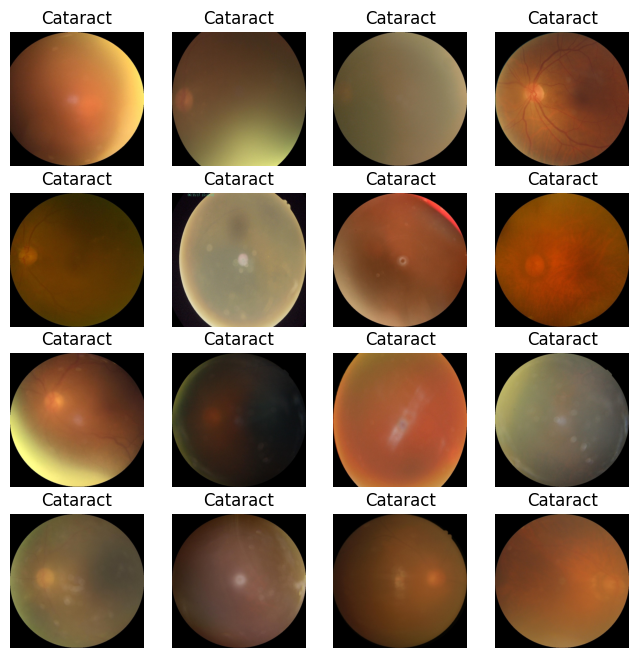

In [17]:
cat = "labeled_images/cataract/"
nor = "labeled_images/normal/"

plot(cat, "Cataract")

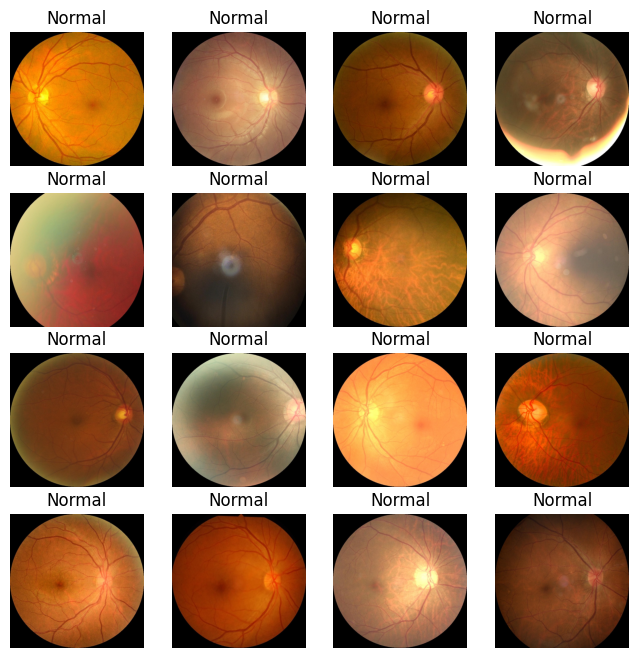

In [18]:
plot(nor, "Normal")

### Generating the dataset

In [19]:
# LOAD THE DATASET
import pathlib
import tensorflow as tf

data_dir = "labeled_images/"
data_dir = pathlib.Path(data_dir)

In [20]:
# PRINT THE NUMBER OF IMAGES IN BOTH CLASSES
image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)

3398


In [21]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3398 files belonging to 2 classes.
Using 2719 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3398 files belonging to 2 classes.
Using 679 files for validation.


In [23]:
class_names = train_ds.class_names
print(class_names)

['cataract', 'normal']


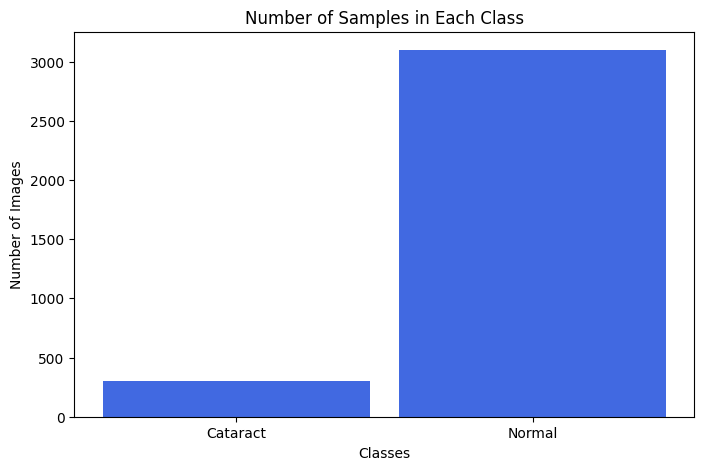

,Class,Count
0,Cataract,300
1,Normal,3098


In [24]:
import pandas as pd 

normal_count = len(list(data_dir.glob('normal/*.*')))
ct_count = len(list(data_dir.glob('cataract/*.*')))

data = {'Cataract':ct_count, 'Normal':normal_count}
classes = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (8, 5))
# creating the bar plot
plt.bar(classes, values, color ='royalblue', width = 0.9)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Number of Samples in Each Class")
plt.show()

data = [['Cataract', ct_count], ['Normal', normal_count]]
df = pd.DataFrame(data, columns=['Class', 'Count'])
df

# Model Building

In [25]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [26]:
num_classes = len(class_names)
tf.random.set_seed(42)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.9),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

In [27]:
model.compile(optimizer='adam', loss='categorical_crossentropy' , metrics=['accuracy'])

In [28]:
# Stops the training if the validation accuracy doesn't improve for x consecutive epochs 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)

# Reduce the learning rate when the validation accuracy stagnates for x consecutive epochs 
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.5, 
                              patience = 5, 
                              min_delta = 0.001,
                              mode='auto',verbose=1)

### Plot History

In [29]:
def history(hist) : 
    # Plot the history for accuracy 
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
    # Plot the history for loss 
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Experiment #1 Without Augmentation and Segmentation

In [30]:
epochs=100
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[callback, reduce_lr]
)

Epoch 1/100
85/85 [==============================] - 9s 54ms/step - loss: 0.3203 - accuracy: 0.9044 - val_loss: 0.2872 - val_accuracy: 0.9087
Epoch 2/100
85/85 [==============================] - 4s 44ms/step - loss: 0.3037 - accuracy: 0.9125 - val_loss: 0.3027 - val_accuracy: 0.9087
Epoch 3/100
85/85 [==============================] - 4s 45ms/step - loss: 0.2933 - accuracy: 0.9125 - val_loss: 0.2907 - val_accuracy: 0.9087
Epoch 4/100
85/85 [==============================] - 4s 46ms/step - loss: 0.2844 - accuracy: 0.9125 - val_loss: 0.2690 - val_accuracy: 0.9087
Epoch 5/100
85/85 [==============================] - 4s 45ms/step - loss: 0.2884 - accuracy: 0.9125 - val_loss: 0.2729 - val_accuracy: 0.9087
Epoch 6/100
85/85 [==============================] - 4s 45ms/step - loss: 0.2788 - accuracy: 0.9125 - val_loss: 0.2702 - val_accuracy: 0.9087

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
85/85 [==============================] - 4s 44ms/step -

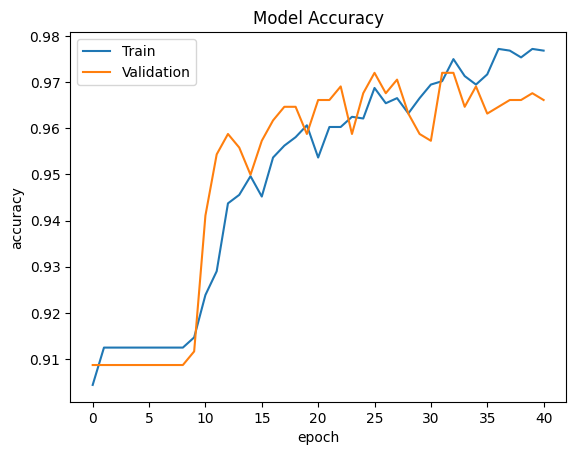

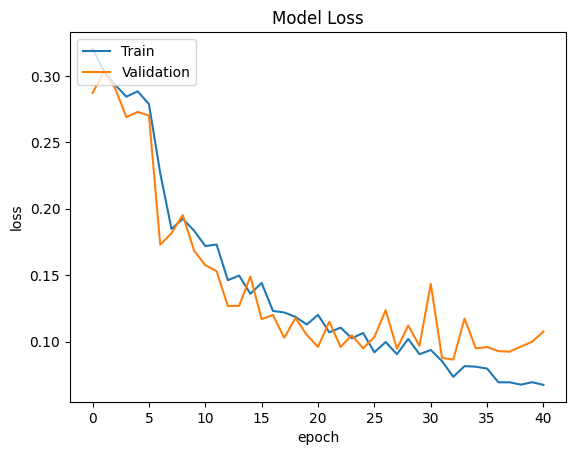

In [31]:
history(hist)

In [32]:
# EVALUATE TRAINING ACCURACY
results = model.evaluate(train_ds)

85/85 [==============================] - 2s 23ms/step - loss: 0.0697 - accuracy: 0.9761


In [33]:
# EVALUATE VALIDATION ACCURACY
results = model.evaluate(val_ds)

22/22 [==============================] - 1s 21ms/step - loss: 0.1076 - accuracy: 0.9661


### Classification Report

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np 

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in val_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])
    
print(classification_report(true_classes, prediction_classes, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    cataract     0.9756    0.6452    0.7767        62
      normal     0.9655    0.9984    0.9817       617

    accuracy                         0.9661       679
   macro avg     0.9706    0.8218    0.8792       679
weighted avg     0.9664    0.9661    0.9630       679



### Confusion matrix

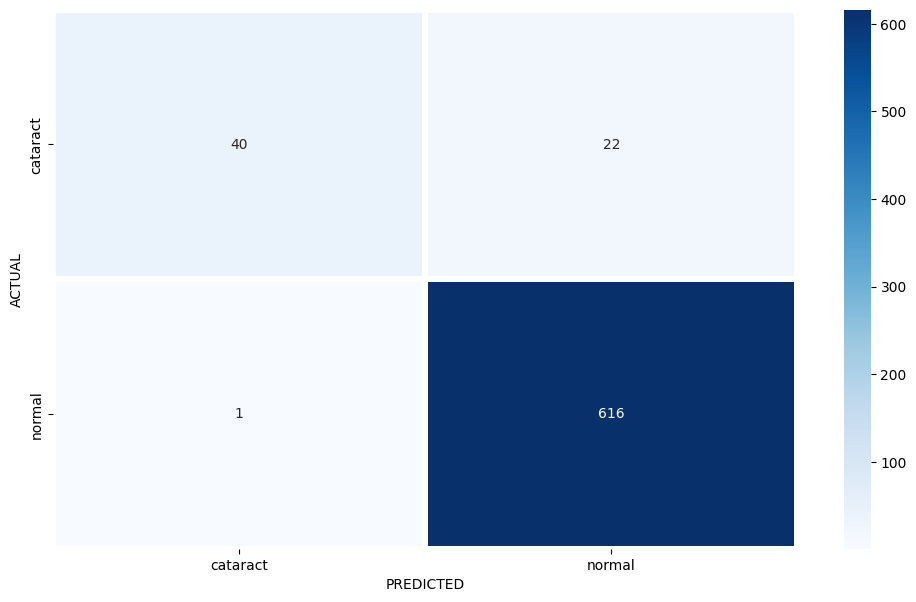

In [35]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
cm = confusion_matrix(true_classes, prediction_classes)

sns.heatmap(cm,cmap="Blues", annot=True,xticklabels=class_names, yticklabels=class_names ,linewidths=3 ,fmt='g')
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.show()

# Experiement #2 With Only Augmentation

In [36]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Set the path to the directory containing the original images
data_dir = 'labeled_images/cataract/'

# Create an ImageDataGenerator object to augment the images
datagen = ImageDataGenerator(
        rotation_range=20, # Randomly rotate images by up to 20 degrees
        horizontal_flip=True, # Randomly flip images horizontally
        fill_mode='constant' # Fill any empty pixels with the nearest value
)

# Loop through each image in the directory and apply the augmentation
for img_name in os.listdir(data_dir):
    img_path = os.path.join(data_dir, img_name)
    img = load_img(img_path)  # Load the image
    x = img_to_array(img)  # Convert the image to a numpy array
    x = x.reshape((1,) + x.shape)  # Reshape the array to include a batch dimension
    i = 0  # Initialize the image counter
    for batch in datagen.flow(x, batch_size=1, save_to_dir=data_dir, save_prefix='aug', save_format='jpg'):
        i += 1
        if i > 10: # Generate 4 augmented images for each original image
            break  # Break the loop to move on to the next image


In [37]:
# LOAD THE DATASET
import pathlib
import tensorflow as tf

data_dir = "labeled_images/"
data_dir = pathlib.Path(data_dir)

In [38]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6226 files belonging to 2 classes.
Using 4981 files for training.


In [39]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6226 files belonging to 2 classes.
Using 1245 files for validation.


### Training

In [40]:
epochs=100
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[reduce_lr, callback]
)

Epoch 1/100
156/156 [==============================] - 8s 49ms/step - loss: 0.2223 - accuracy: 0.9173 - val_loss: 0.1680 - val_accuracy: 0.9269
Epoch 2/100
156/156 [==============================] - 7s 45ms/step - loss: 0.1875 - accuracy: 0.9285 - val_loss: 0.1609 - val_accuracy: 0.9365
Epoch 3/100
156/156 [==============================] - 7s 44ms/step - loss: 0.1736 - accuracy: 0.9313 - val_loss: 0.1529 - val_accuracy: 0.9325
Epoch 4/100
156/156 [==============================] - 7s 45ms/step - loss: 0.1629 - accuracy: 0.9346 - val_loss: 0.1473 - val_accuracy: 0.9333
Epoch 5/100
156/156 [==============================] - 7s 47ms/step - loss: 0.1567 - accuracy: 0.9390 - val_loss: 0.1430 - val_accuracy: 0.9357
Epoch 6/100
156/156 [==============================] - 8s 49ms/step - loss: 0.1521 - accuracy: 0.9408 - val_loss: 0.1338 - val_accuracy: 0.9422
Epoch 7/100
156/156 [==============================] - 8s 53ms/step - loss: 0.1390 - accuracy: 0.9462 - val_loss: 0.1280 - val_accuracy:

Epoch 55/100
156/156 [==============================] - 7s 46ms/step - loss: 0.0387 - accuracy: 0.9857 - val_loss: 0.0521 - val_accuracy: 0.9815
Epoch 56/100
156/156 [==============================] - 7s 44ms/step - loss: 0.0371 - accuracy: 0.9859 - val_loss: 0.0515 - val_accuracy: 0.9807

Epoch 00056: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 57/100
156/156 [==============================] - 7s 45ms/step - loss: 0.0384 - accuracy: 0.9861 - val_loss: 0.0518 - val_accuracy: 0.9823
Epoch 58/100
156/156 [==============================] - 7s 45ms/step - loss: 0.0372 - accuracy: 0.9878 - val_loss: 0.0521 - val_accuracy: 0.9823


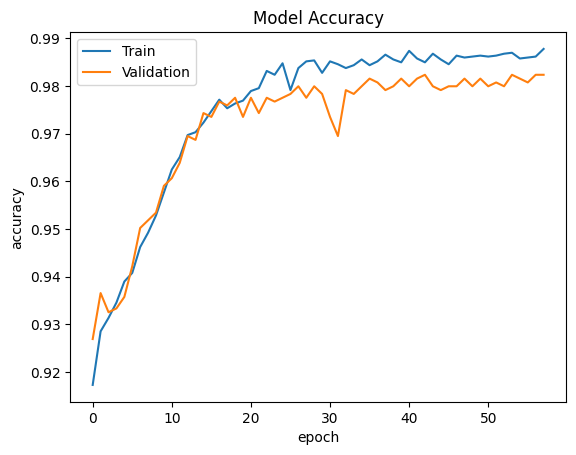

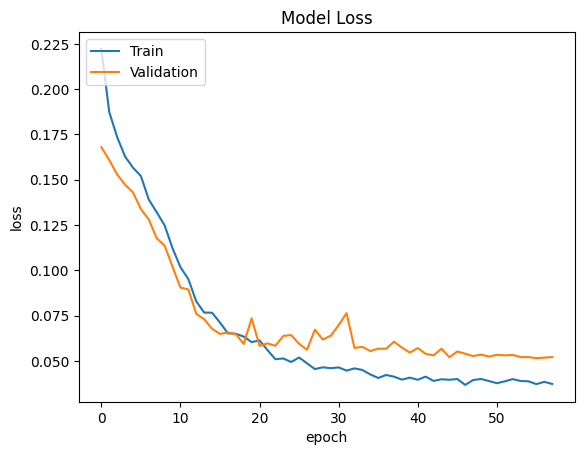

In [41]:
history(hist)

In [42]:
# EVALUATE TRAINING ACCURACY
results = model.evaluate(train_ds)

156/156 [==============================] - 4s 24ms/step - loss: 0.0315 - accuracy: 0.9886


In [43]:
# EVALUATE VALIDATION ACCURACY
results = model.evaluate(val_ds)

39/39 [==============================] - 1s 22ms/step - loss: 0.0521 - accuracy: 0.9823


### Classification Report

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np 

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in val_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])
    
print(classification_report(true_classes, prediction_classes, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    cataract     0.9917    0.9724    0.9820       617
      normal     0.9734    0.9920    0.9826       628

    accuracy                         0.9823      1245
   macro avg     0.9826    0.9822    0.9823      1245
weighted avg     0.9825    0.9823    0.9823      1245



### Confusion matrix

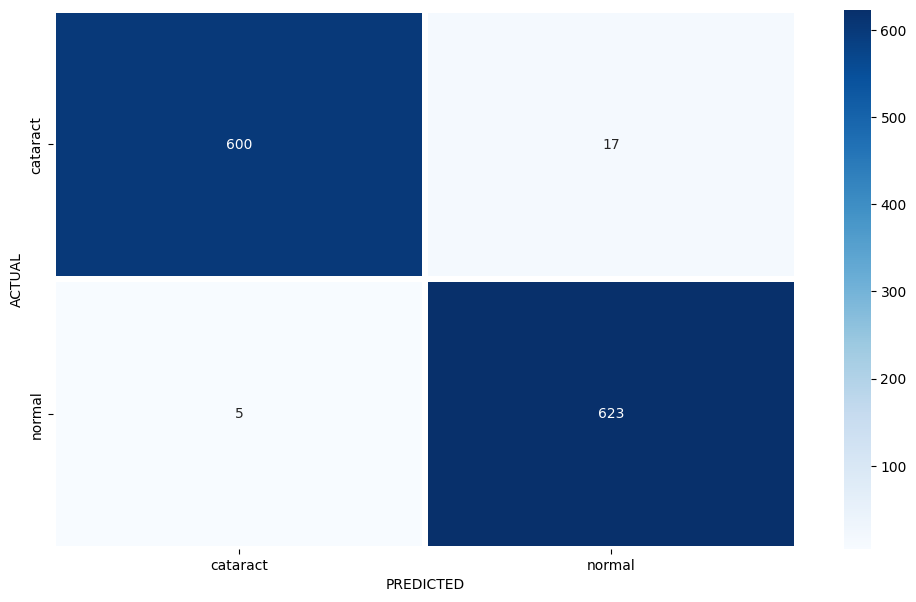

In [45]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
cm = confusion_matrix(true_classes, prediction_classes)

sns.heatmap(cm,cmap="Blues", annot=True,xticklabels=class_names, yticklabels=class_names ,linewidths=3 ,fmt='g')
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.show()

# Experiement #3 With Augmentation and Segementation

### Segement images in all classes

In [46]:
cataract_dir = "labeled_images/cataract/"
normal_dir = "labeled_images/normal/"

if __name__ == "__main__":

    SOURCE_DIRECTORY = cataract_dir
    directory_list = os.listdir(SOURCE_DIRECTORY)

    filelist = []
    for source_file in directory_list:
        source_path = os.path.join(SOURCE_DIRECTORY, source_file)
        if os.path.isfile(source_path):
            filelist.append(source_path)
            
    with Pool(16) as pool:  # 16 is number of processes we want to use
        for result in pool.imap_unordered(remove_background, filelist):
            print(result)

labeled_images/cataract/0_left background is removed.
labeled_images/cataract/1083_left background is removed.
labeled_images/cataract/1101_right background is removed.
labeled_images/cataract/103_left background is removed.
labeled_images/cataract/1062_right background is removed.
labeled_images/cataract/112_right background is removed.
labeled_images/cataract/1285_left background is removed.
labeled_images/cataract/1415_left background is removed.
labeled_images/cataract/1415_right background is removed.
labeled_images/cataract/1435_left background is removed.
labeled_images/cataract/1444_left background is removed.
labeled_images/cataract/1102_right background is removed.
labeled_images/cataract/1452_left background is removed.
labeled_images/cataract/1115_left background is removed.
labeled_images/cataract/1456_left background is removed.
labeled_images/cataract/1456_right background is removed.
labeled_images/cataract/1454_right background is removed.
labeled_images/cataract/1144_

labeled_images/cataract/2225_right background is removed.
labeled_images/cataract/2226_left background is removed.
labeled_images/cataract/2225_left background is removed.
labeled_images/cataract/2227_left background is removed.
labeled_images/cataract/2226_right background is removed.
labeled_images/cataract/2227_right background is removed.
labeled_images/cataract/2228_right background is removed.
labeled_images/cataract/2229_right background is removed.
labeled_images/cataract/2230_right background is removed.
labeled_images/cataract/2233_left background is removed.
labeled_images/cataract/2233_right background is removed.
labeled_images/cataract/2232_right background is removed.
labeled_images/cataract/2230_left background is removed.
labeled_images/cataract/2229_left background is removed.
labeled_images/cataract/2234_left background is removed.
labeled_images/cataract/2231_right background is removed.
labeled_images/cataract/2234_right background is removed.
labeled_images/catara

labeled_images/cataract/aug_0_1540 background is removed.
labeled_images/cataract/aug_0_1528 background is removed.
labeled_images/cataract/aug_0_1539 background is removed.
labeled_images/cataract/aug_0_1535 background is removed.
labeled_images/cataract/aug_0_1562 background is removed.
labeled_images/cataract/aug_0_1542 background is removed.
labeled_images/cataract/aug_0_1536 background is removed.
labeled_images/cataract/aug_0_1572 background is removed.
labeled_images/cataract/aug_0_1573 background is removed.
labeled_images/cataract/aug_0_1546 background is removed.
labeled_images/cataract/aug_0_158 background is removed.
labeled_images/cataract/aug_0_1575 background is removed.
labeled_images/cataract/aug_0_1579 background is removed.
labeled_images/cataract/aug_0_1578 background is removed.
labeled_images/cataract/aug_0_1549 background is removed.
labeled_images/cataract/aug_0_1582 background is removed.
labeled_images/cataract/aug_0_1589 background is removed.
labeled_images/

labeled_images/cataract/aug_0_2402 background is removed.
labeled_images/cataract/aug_0_2422 background is removed.
labeled_images/cataract/aug_0_2424 background is removed.
labeled_images/cataract/aug_0_2409 background is removed.
labeled_images/cataract/aug_0_241 background is removed.
labeled_images/cataract/aug_0_2417 background is removed.
labeled_images/cataract/aug_0_2431 background is removed.
labeled_images/cataract/aug_0_2433 background is removed.
labeled_images/cataract/aug_0_2436 background is removed.
labeled_images/cataract/aug_0_2428 background is removed.
labeled_images/cataract/aug_0_2432 background is removed.
labeled_images/cataract/aug_0_2430 background is removed.
labeled_images/cataract/aug_0_2448 background is removed.
labeled_images/cataract/aug_0_2449 background is removed.
labeled_images/cataract/aug_0_2440 background is removed.
labeled_images/cataract/aug_0_2419 background is removed.
labeled_images/cataract/aug_0_245 background is removed.
labeled_images/c

labeled_images/cataract/aug_0_2969 background is removed.
labeled_images/cataract/aug_0_2978 background is removed.
labeled_images/cataract/aug_0_2968 background is removed.
labeled_images/cataract/aug_0_2960 background is removed.
labeled_images/cataract/aug_0_2977 background is removed.
labeled_images/cataract/aug_0_2985 background is removed.
labeled_images/cataract/aug_0_2982 background is removed.
labeled_images/cataract/aug_0_2981 background is removed.
labeled_images/cataract/aug_0_2952 background is removed.
labeled_images/cataract/aug_0_2964 background is removed.
labeled_images/cataract/aug_0_299 background is removed.
labeled_images/cataract/aug_0_2992 background is removed.
labeled_images/cataract/aug_0_2927 background is removed.
labeled_images/cataract/aug_0_3018 background is removed.
labeled_images/cataract/aug_0_3015 background is removed.
labeled_images/cataract/aug_0_2998 background is removed.
labeled_images/cataract/aug_0_2997 background is removed.
labeled_images/

labeled_images/cataract/aug_0_3750 background is removed.
labeled_images/cataract/aug_0_3768 background is removed.
labeled_images/cataract/aug_0_3764 background is removed.
labeled_images/cataract/aug_0_3766 background is removed.
labeled_images/cataract/aug_0_3758 background is removed.
labeled_images/cataract/aug_0_3776 background is removed.
labeled_images/cataract/aug_0_3780 background is removed.
labeled_images/cataract/aug_0_3786 background is removed.
labeled_images/cataract/aug_0_3772 background is removed.
labeled_images/cataract/aug_0_3774 background is removed.
labeled_images/cataract/aug_0_3756 background is removed.
labeled_images/cataract/aug_0_3796 background is removed.
labeled_images/cataract/aug_0_3789 background is removed.
labeled_images/cataract/aug_0_3795 background is removed.
labeled_images/cataract/aug_0_38 background is removed.
labeled_images/cataract/aug_0_3788 background is removed.
labeled_images/cataract/aug_0_3798 background is removed.
labeled_images/c

labeled_images/cataract/aug_0_438 background is removed.
labeled_images/cataract/aug_0_4374 background is removed.
labeled_images/cataract/aug_0_4307 background is removed.
labeled_images/cataract/aug_0_4385 background is removed.
labeled_images/cataract/aug_0_4391 background is removed.
labeled_images/cataract/aug_0_4393 background is removed.
labeled_images/cataract/aug_0_4306 background is removed.
labeled_images/cataract/aug_0_4398 background is removed.
labeled_images/cataract/aug_0_4394 background is removed.
labeled_images/cataract/aug_0_4382 background is removed.
labeled_images/cataract/aug_0_4395 background is removed.
labeled_images/cataract/aug_0_4397 background is removed.
labeled_images/cataract/aug_0_4400 background is removed.
labeled_images/cataract/aug_0_4406 background is removed.
labeled_images/cataract/aug_0_4417 background is removed.
labeled_images/cataract/aug_0_4410 background is removed.
labeled_images/cataract/aug_0_4418 background is removed.
labeled_images/

labeled_images/cataract/aug_0_4912 background is removed.
labeled_images/cataract/aug_0_4907 background is removed.
labeled_images/cataract/aug_0_4908 background is removed.
labeled_images/cataract/aug_0_4914 background is removed.
labeled_images/cataract/aug_0_4911 background is removed.
labeled_images/cataract/aug_0_4901 background is removed.
labeled_images/cataract/aug_0_4872 background is removed.
labeled_images/cataract/aug_0_4905 background is removed.
labeled_images/cataract/aug_0_4915 background is removed.
labeled_images/cataract/aug_0_4917 background is removed.
labeled_images/cataract/aug_0_489 background is removed.
labeled_images/cataract/aug_0_4925 background is removed.
labeled_images/cataract/aug_0_4904 background is removed.
labeled_images/cataract/aug_0_4876 background is removed.
labeled_images/cataract/aug_0_4938 background is removed.
labeled_images/cataract/aug_0_4933 background is removed.
labeled_images/cataract/aug_0_4930 background is removed.
labeled_images/

labeled_images/cataract/aug_0_5664 background is removed.
labeled_images/cataract/aug_0_5662 background is removed.
labeled_images/cataract/aug_0_5661 background is removed.
labeled_images/cataract/aug_0_5668 background is removed.
labeled_images/cataract/aug_0_568 background is removed.
labeled_images/cataract/aug_0_5667 background is removed.
labeled_images/cataract/aug_0_5686 background is removed.
labeled_images/cataract/aug_0_5684 background is removed.
labeled_images/cataract/aug_0_5685 background is removed.
labeled_images/cataract/aug_0_5674 background is removed.
labeled_images/cataract/aug_0_5671 background is removed.
labeled_images/cataract/aug_0_5688 background is removed.
labeled_images/cataract/aug_0_5687 background is removed.
labeled_images/cataract/aug_0_5690 background is removed.
labeled_images/cataract/aug_0_5692 background is removed.
labeled_images/cataract/aug_0_570 background is removed.
labeled_images/cataract/aug_0_5689 background is removed.
labeled_images/c

labeled_images/cataract/aug_0_6265 background is removed.
labeled_images/cataract/aug_0_63 background is removed.
labeled_images/cataract/aug_0_6216 background is removed.
labeled_images/cataract/aug_0_6303 background is removed.
labeled_images/cataract/aug_0_6255 background is removed.
labeled_images/cataract/aug_0_6269 background is removed.
labeled_images/cataract/aug_0_6286 background is removed.
labeled_images/cataract/aug_0_6314 background is removed.
labeled_images/cataract/aug_0_6260 background is removed.
labeled_images/cataract/aug_0_6316 background is removed.
labeled_images/cataract/aug_0_6324 background is removed.
labeled_images/cataract/aug_0_6323 background is removed.
labeled_images/cataract/aug_0_6326 background is removed.
labeled_images/cataract/aug_0_6328 background is removed.
labeled_images/cataract/aug_0_6327 background is removed.
labeled_images/cataract/aug_0_633 background is removed.
labeled_images/cataract/aug_0_632 background is removed.
labeled_images/cat

labeled_images/cataract/aug_0_691 background is removed.
labeled_images/cataract/aug_0_6940 background is removed.
labeled_images/cataract/aug_0_6929 background is removed.
labeled_images/cataract/aug_0_6923 background is removed.
labeled_images/cataract/aug_0_693 background is removed.
labeled_images/cataract/aug_0_6945 background is removed.
labeled_images/cataract/aug_0_6924 background is removed.
labeled_images/cataract/aug_0_6947 background is removed.
labeled_images/cataract/aug_0_697 background is removed.
labeled_images/cataract/aug_0_6962 background is removed.
labeled_images/cataract/aug_0_6944 background is removed.
labeled_images/cataract/aug_0_6963 background is removed.
labeled_images/cataract/aug_0_6946 background is removed.
labeled_images/cataract/aug_0_6973 background is removed.
labeled_images/cataract/aug_0_6977 background is removed.
labeled_images/cataract/aug_0_6980 background is removed.
labeled_images/cataract/aug_0_698 background is removed.
labeled_images/cat

labeled_images/cataract/aug_0_7599 background is removed.
labeled_images/cataract/aug_0_7596 background is removed.
labeled_images/cataract/aug_0_7614 background is removed.
labeled_images/cataract/aug_0_7608 background is removed.
labeled_images/cataract/aug_0_7628 background is removed.
labeled_images/cataract/aug_0_7630 background is removed.
labeled_images/cataract/aug_0_7579 background is removed.
labeled_images/cataract/aug_0_7638 background is removed.
labeled_images/cataract/aug_0_7560 background is removed.
labeled_images/cataract/aug_0_7637 background is removed.
labeled_images/cataract/aug_0_7641 background is removed.
labeled_images/cataract/aug_0_7635 background is removed.
labeled_images/cataract/aug_0_7632 background is removed.
labeled_images/cataract/aug_0_7646 background is removed.
labeled_images/cataract/aug_0_7639 background is removed.
labeled_images/cataract/aug_0_7642 background is removed.
labeled_images/cataract/aug_0_7643 background is removed.
labeled_images

labeled_images/cataract/aug_0_8052 background is removed.
labeled_images/cataract/aug_0_8065 background is removed.
labeled_images/cataract/aug_0_7930 background is removed.
labeled_images/cataract/aug_0_8081 background is removed.
labeled_images/cataract/aug_0_8086 background is removed.
labeled_images/cataract/aug_0_8077 background is removed.
labeled_images/cataract/aug_0_8034 background is removed.
labeled_images/cataract/aug_0_8085 background is removed.
labeled_images/cataract/aug_0_8084 background is removed.
labeled_images/cataract/aug_0_8079 background is removed.
labeled_images/cataract/aug_0_809 background is removed.
labeled_images/cataract/aug_0_8095 background is removed.
labeled_images/cataract/aug_0_8094 background is removed.
labeled_images/cataract/aug_0_8100 background is removed.
labeled_images/cataract/aug_0_8097 background is removed.
labeled_images/cataract/aug_0_7985 background is removed.
labeled_images/cataract/aug_0_811 background is removed.
labeled_images/c

labeled_images/cataract/aug_0_8666 background is removed.
labeled_images/cataract/aug_0_8661 background is removed.
labeled_images/cataract/aug_0_8686 background is removed.
labeled_images/cataract/aug_0_8669 background is removed.
labeled_images/cataract/aug_0_8698 background is removed.
labeled_images/cataract/aug_0_8702 background is removed.
labeled_images/cataract/aug_0_87 background is removed.
labeled_images/cataract/aug_0_8708 background is removed.
labeled_images/cataract/aug_0_8717 background is removed.
labeled_images/cataract/aug_0_8712 background is removed.
labeled_images/cataract/aug_0_8727 background is removed.
labeled_images/cataract/aug_0_8714 background is removed.
labeled_images/cataract/aug_0_8731 background is removed.
labeled_images/cataract/aug_0_8683 background is removed.
labeled_images/cataract/aug_0_8737 background is removed.
labeled_images/cataract/aug_0_8741 background is removed.
labeled_images/cataract/aug_0_8732 background is removed.
labeled_images/c

labeled_images/cataract/aug_0_935 background is removed.
labeled_images/cataract/aug_0_9360 background is removed.
labeled_images/cataract/aug_0_9368 background is removed.
labeled_images/cataract/aug_0_9380 background is removed.
labeled_images/cataract/aug_0_9377 background is removed.
labeled_images/cataract/aug_0_9346 background is removed.
labeled_images/cataract/aug_0_9364 background is removed.
labeled_images/cataract/aug_0_9370 background is removed.
labeled_images/cataract/aug_0_9378 background is removed.
labeled_images/cataract/aug_0_9336 background is removed.
labeled_images/cataract/aug_0_9381 background is removed.
labeled_images/cataract/aug_0_9393 background is removed.
labeled_images/cataract/aug_0_9382 background is removed.
labeled_images/cataract/aug_0_9385 background is removed.
labeled_images/cataract/aug_0_9395 background is removed.
labeled_images/cataract/aug_0_939 background is removed.
labeled_images/cataract/aug_0_9405 background is removed.
labeled_images/c

In [47]:
SOURCE_DIRECTORY = normal_dir
directory_list = os.listdir(SOURCE_DIRECTORY)

filelist = []
for source_file in directory_list:
    source_path = os.path.join(SOURCE_DIRECTORY, source_file)
    if os.path.isfile(source_path):
        filelist.append(source_path)

with Pool(16) as pool:  # 16 is number of processes we want to use
    for result in pool.imap_unordered(remove_background, filelist):
        print(result)

labeled_images/normal/1005_right background is removed.
labeled_images/normal/1028_right background is removed.
labeled_images/normal/0_right background is removed.
labeled_images/normal/1008_left background is removed.
labeled_images/normal/1032_left background is removed.
labeled_images/normal/1006_left background is removed.
labeled_images/normal/1034_left background is removed.
labeled_images/normal/1033_left background is removed.
labeled_images/normal/1034_right background is removed.
labeled_images/normal/1035_left background is removed.
labeled_images/normal/1036_left background is removed.
labeled_images/normal/1038_left background is removed.
labeled_images/normal/100_right background is removed.
labeled_images/normal/1011_left background is removed.
labeled_images/normal/1039_right background is removed.
labeled_images/normal/103_right background is removed.
labeled_images/normal/1040_right background is removed.
labeled_images/normal/1014_right background is removed.
labele

labeled_images/normal/1876_left background is removed.
labeled_images/normal/1873_left background is removed.
labeled_images/normal/189_left background is removed.
labeled_images/normal/1890_right background is removed.
labeled_images/normal/187_left background is removed.
labeled_images/normal/190_left background is removed.
labeled_images/normal/191_left background is removed.
labeled_images/normal/191_right background is removed.
labeled_images/normal/1_right background is removed.
labeled_images/normal/1990_left background is removed.
labeled_images/normal/194_left background is removed.
labeled_images/normal/1_left background is removed.
labeled_images/normal/1975_right background is removed.
labeled_images/normal/196_right background is removed.
labeled_images/normal/2010_right background is removed.
labeled_images/normal/200_right background is removed.
labeled_images/normal/197_left background is removed.
labeled_images/normal/202_left background is removed.
labeled_images/norm

labeled_images/normal/2364_left background is removed.
labeled_images/normal/2381_right background is removed.
labeled_images/normal/2381_left background is removed.
labeled_images/normal/2380_left background is removed.
labeled_images/normal/2382_right background is removed.
labeled_images/normal/2380_right background is removed.
labeled_images/normal/237_left background is removed.
labeled_images/normal/2383_left background is removed.
labeled_images/normal/2382_left background is removed.
labeled_images/normal/2385_right background is removed.
labeled_images/normal/2384_left background is removed.
labeled_images/normal/2386_left background is removed.
labeled_images/normal/2386_right background is removed.
labeled_images/normal/2385_left background is removed.
labeled_images/normal/2387_right background is removed.
labeled_images/normal/2387_left background is removed.
labeled_images/normal/2383_right background is removed.
labeled_images/normal/2388_right background is removed.
lab

labeled_images/normal/2452_left background is removed.
labeled_images/normal/2463_left background is removed.
labeled_images/normal/2460_right background is removed.
labeled_images/normal/2464_right background is removed.
labeled_images/normal/2465_left background is removed.
labeled_images/normal/2465_right background is removed.
labeled_images/normal/2467_right background is removed.
labeled_images/normal/2466_right background is removed.
labeled_images/normal/2467_left background is removed.
labeled_images/normal/2462_right background is removed.
labeled_images/normal/2466_left background is removed.
labeled_images/normal/2468_left background is removed.
labeled_images/normal/2468_right background is removed.
labeled_images/normal/2463_right background is removed.
labeled_images/normal/2469_right background is removed.
labeled_images/normal/2461_right background is removed.
labeled_images/normal/2464_left background is removed.
labeled_images/normal/2470_left background is removed.


labeled_images/normal/2585_left background is removed.
labeled_images/normal/2584_right background is removed.
labeled_images/normal/2586_left background is removed.
labeled_images/normal/2586_right background is removed.
labeled_images/normal/2588_left background is removed.
labeled_images/normal/2589_right background is removed.
labeled_images/normal/2588_right background is removed.
labeled_images/normal/2587_left background is removed.
labeled_images/normal/2589_left background is removed.
labeled_images/normal/2587_right background is removed.
labeled_images/normal/2590_left background is removed.
labeled_images/normal/258_left background is removed.
labeled_images/normal/2590_right background is removed.
labeled_images/normal/2592_right background is removed.
labeled_images/normal/2592_left background is removed.
labeled_images/normal/2591_left background is removed.
labeled_images/normal/2591_right background is removed.
labeled_images/normal/2593_right background is removed.
la

labeled_images/normal/2660_left background is removed.
labeled_images/normal/2679_left background is removed.
labeled_images/normal/2682_right background is removed.
labeled_images/normal/2681_right background is removed.
labeled_images/normal/2681_left background is removed.
labeled_images/normal/2680_right background is removed.
labeled_images/normal/2683_right background is removed.
labeled_images/normal/2683_left background is removed.
labeled_images/normal/2682_left background is removed.
labeled_images/normal/267_right background is removed.
labeled_images/normal/2678_left background is removed.
labeled_images/normal/2686_right background is removed.
labeled_images/normal/2678_right background is removed.
labeled_images/normal/2685_right background is removed.
labeled_images/normal/2679_right background is removed.
labeled_images/normal/2687_left background is removed.
labeled_images/normal/2687_right background is removed.
labeled_images/normal/2684_left background is removed.
l

labeled_images/normal/2758_right background is removed.
labeled_images/normal/2756_right background is removed.
labeled_images/normal/275_left background is removed.
labeled_images/normal/2758_left background is removed.
labeled_images/normal/2757_left background is removed.
labeled_images/normal/2755_left background is removed.
labeled_images/normal/2757_right background is removed.
labeled_images/normal/2762_left background is removed.
labeled_images/normal/2761_left background is removed.
labeled_images/normal/2760_right background is removed.
labeled_images/normal/2759_left background is removed.
labeled_images/normal/2761_right background is removed.
labeled_images/normal/2759_right background is removed.
labeled_images/normal/2760_left background is removed.
labeled_images/normal/2762_right background is removed.
labeled_images/normal/2763_left background is removed.
labeled_images/normal/2763_right background is removed.
labeled_images/normal/2764_left background is removed.
lab

labeled_images/normal/2853_right background is removed.
labeled_images/normal/2853_left background is removed.
labeled_images/normal/2855_left background is removed.
labeled_images/normal/2854_left background is removed.
labeled_images/normal/2855_right background is removed.
labeled_images/normal/2854_right background is removed.
labeled_images/normal/2858_left background is removed.
labeled_images/normal/2857_left background is removed.
labeled_images/normal/2858_right background is removed.
labeled_images/normal/2856_left background is removed.
labeled_images/normal/2860_left background is removed.
labeled_images/normal/2859_left background is removed.
labeled_images/normal/2859_right background is removed.
labeled_images/normal/2857_right background is removed.
labeled_images/normal/2856_right background is removed.
labeled_images/normal/2861_left background is removed.
labeled_images/normal/2860_right background is removed.
labeled_images/normal/285_left background is removed.
lab

labeled_images/normal/2932_right background is removed.
labeled_images/normal/2931_right background is removed.
labeled_images/normal/2933_left background is removed.
labeled_images/normal/2929_left background is removed.
labeled_images/normal/2933_right background is removed.
labeled_images/normal/2934_left background is removed.
labeled_images/normal/2935_right background is removed.
labeled_images/normal/2934_right background is removed.
labeled_images/normal/2935_left background is removed.
labeled_images/normal/2936_left background is removed.
labeled_images/normal/2938_right background is removed.
labeled_images/normal/2938_left background is removed.
labeled_images/normal/2937_right background is removed.
labeled_images/normal/2937_left background is removed.
labeled_images/normal/2939_right background is removed.
labeled_images/normal/293_right background is removed.
labeled_images/normal/2941_left background is removed.
labeled_images/normal/2941_right background is removed.
l

labeled_images/normal/3012_left background is removed.
labeled_images/normal/3013_left background is removed.
labeled_images/normal/3014_left background is removed.
labeled_images/normal/3009_left background is removed.
labeled_images/normal/3013_right background is removed.
labeled_images/normal/3012_right background is removed.
labeled_images/normal/3014_right background is removed.
labeled_images/normal/3015_left background is removed.
labeled_images/normal/3015_right background is removed.
labeled_images/normal/3017_left background is removed.
labeled_images/normal/3016_left background is removed.
labeled_images/normal/3017_right background is removed.
labeled_images/normal/3016_right background is removed.
labeled_images/normal/3019_left background is removed.
labeled_images/normal/3018_right background is removed.
labeled_images/normal/3020_left background is removed.
labeled_images/normal/3018_left background is removed.
labeled_images/normal/3020_right background is removed.
la

labeled_images/normal/3105_right background is removed.
labeled_images/normal/3102_left background is removed.
labeled_images/normal/3107_left background is removed.
labeled_images/normal/3107_right background is removed.
labeled_images/normal/3106_left background is removed.
labeled_images/normal/3108_right background is removed.
labeled_images/normal/3108_left background is removed.
labeled_images/normal/310_left background is removed.
labeled_images/normal/3109_left background is removed.
labeled_images/normal/3110_right background is removed.
labeled_images/normal/3112_left background is removed.
labeled_images/normal/3110_left background is removed.
labeled_images/normal/3109_right background is removed.
labeled_images/normal/3112_right background is removed.
labeled_images/normal/3111_right background is removed.
labeled_images/normal/3111_left background is removed.
labeled_images/normal/3113_left background is removed.
labeled_images/normal/3115_left background is removed.
labe

labeled_images/normal/317_left background is removed.
labeled_images/normal/3180_left background is removed.
labeled_images/normal/3179_right background is removed.
labeled_images/normal/3182_right background is removed.
labeled_images/normal/3181_right background is removed.
labeled_images/normal/3180_right background is removed.
labeled_images/normal/3184_left background is removed.
labeled_images/normal/3182_left background is removed.
labeled_images/normal/3181_left background is removed.
labeled_images/normal/3185_left background is removed.
labeled_images/normal/3185_right background is removed.
labeled_images/normal/3183_left background is removed.
labeled_images/normal/3186_right background is removed.
labeled_images/normal/3183_right background is removed.
labeled_images/normal/3184_right background is removed.
labeled_images/normal/3187_right background is removed.
labeled_images/normal/3186_left background is removed.
labeled_images/normal/3187_left background is removed.
la

labeled_images/normal/3276_left background is removed.
labeled_images/normal/3275_left background is removed.
labeled_images/normal/3276_right background is removed.
labeled_images/normal/3275_right background is removed.
labeled_images/normal/3279_left background is removed.
labeled_images/normal/3278_left background is removed.
labeled_images/normal/3278_right background is removed.
labeled_images/normal/3274_right background is removed.
labeled_images/normal/3277_left background is removed.
labeled_images/normal/3277_right background is removed.
labeled_images/normal/3281_left background is removed.
labeled_images/normal/3279_right background is removed.
labeled_images/normal/3281_right background is removed.
labeled_images/normal/3280_left background is removed.
labeled_images/normal/3282_left background is removed.
labeled_images/normal/3280_right background is removed.
labeled_images/normal/3283_right background is removed.
labeled_images/normal/3283_left background is removed.
l

labeled_images/normal/3365_left background is removed.
labeled_images/normal/3363_left background is removed.
labeled_images/normal/3363_right background is removed.
labeled_images/normal/3364_left background is removed.
labeled_images/normal/3351_left background is removed.
labeled_images/normal/3364_right background is removed.
labeled_images/normal/3365_right background is removed.
labeled_images/normal/3366_left background is removed.
labeled_images/normal/3358_right background is removed.
labeled_images/normal/3367_left background is removed.
labeled_images/normal/3366_right background is removed.
labeled_images/normal/3367_right background is removed.
labeled_images/normal/3368_left background is removed.
labeled_images/normal/3368_right background is removed.
labeled_images/normal/3360_right background is removed.
labeled_images/normal/3369_left background is removed.
labeled_images/normal/3362_left background is removed.
labeled_images/normal/336_right background is removed.
la

labeled_images/normal/3446_right background is removed.
labeled_images/normal/3445_left background is removed.
labeled_images/normal/3444_right background is removed.
labeled_images/normal/3445_right background is removed.
labeled_images/normal/3446_left background is removed.
labeled_images/normal/3450_left background is removed.
labeled_images/normal/3448_right background is removed.
labeled_images/normal/3450_right background is removed.
labeled_images/normal/346_left background is removed.
labeled_images/normal/3485_left background is removed.
labeled_images/normal/3485_right background is removed.
labeled_images/normal/347_left background is removed.
labeled_images/normal/351_right background is removed.
labeled_images/normal/353_left background is removed.
labeled_images/normal/349_left background is removed.
labeled_images/normal/356_left background is removed.
labeled_images/normal/3448_left background is removed.
labeled_images/normal/362_left background is removed.
labeled_im

labeled_images/normal/4354_right background is removed.
labeled_images/normal/4360_left background is removed.
labeled_images/normal/436_left background is removed.
labeled_images/normal/4377_left background is removed.
labeled_images/normal/4373_left background is removed.
labeled_images/normal/4362_right background is removed.
labeled_images/normal/4374_left background is removed.
labeled_images/normal/437_left background is removed.
labeled_images/normal/4389_right background is removed.
labeled_images/normal/438_right background is removed.
labeled_images/normal/4387_left background is removed.
labeled_images/normal/4395_right background is removed.
labeled_images/normal/4409_right background is removed.
labeled_images/normal/4392_left background is removed.
labeled_images/normal/439_left background is removed.
labeled_images/normal/4408_right background is removed.
labeled_images/normal/440_left background is removed.
labeled_images/normal/4411_right background is removed.
labeled

labeled_images/normal/670_right background is removed.
labeled_images/normal/689_right background is removed.
labeled_images/normal/68_left background is removed.
labeled_images/normal/693_right background is removed.
labeled_images/normal/695_left background is removed.
labeled_images/normal/694_right background is removed.
labeled_images/normal/696_right background is removed.
labeled_images/normal/695_right background is removed.
labeled_images/normal/701_left background is removed.
labeled_images/normal/702_left background is removed.
labeled_images/normal/69_left background is removed.
labeled_images/normal/705_right background is removed.
labeled_images/normal/710_left background is removed.
labeled_images/normal/704_right background is removed.
labeled_images/normal/715_right background is removed.
labeled_images/normal/716_left background is removed.
labeled_images/normal/70_right background is removed.
labeled_images/normal/717_right background is removed.
labeled_images/norma

### Plot segemented images

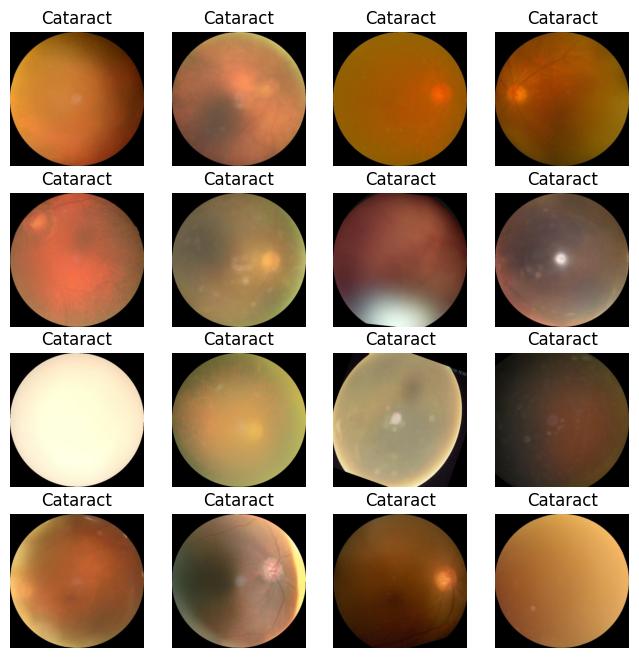

In [48]:
cat = "labeled_images/cataract/"
nor = "labeled_images/normal/"

plot(cat, "Cataract")

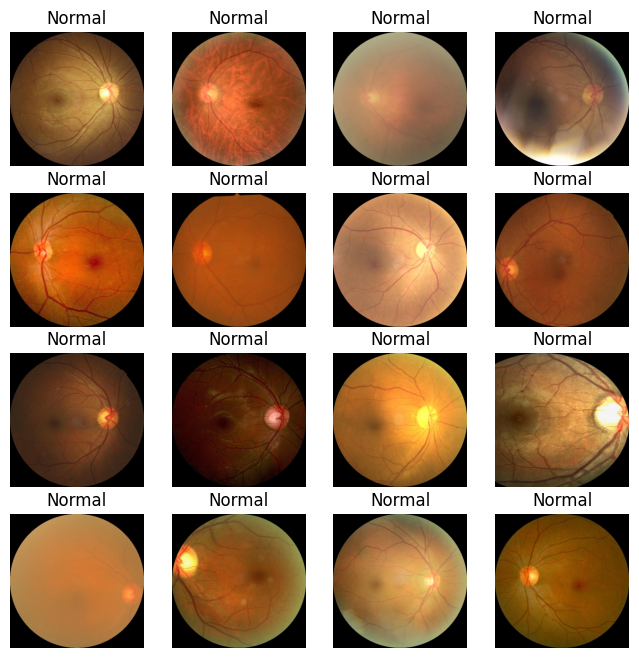

In [49]:
plot(nor, "Normal")

### Generate dataset

In [50]:
# LOAD THE DATASET
import pathlib
import tensorflow as tf

data_dir = "labeled_images/"
data_dir = pathlib.Path(data_dir)

In [51]:
batch_size = 32
img_height = 256
img_width = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6226 files belonging to 2 classes.
Using 4981 files for training.


In [52]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6226 files belonging to 2 classes.
Using 1245 files for validation.


In [59]:
epochs=100
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[reduce_lr, callback]
)

Epoch 1/100
156/156 [==============================] - 7s 44ms/step - loss: 0.0388 - accuracy: 0.9855 - val_loss: 0.0548 - val_accuracy: 0.9783
Epoch 2/100
156/156 [==============================] - 7s 44ms/step - loss: 0.0436 - accuracy: 0.9855 - val_loss: 0.0548 - val_accuracy: 0.9783
Epoch 3/100
156/156 [==============================] - 7s 43ms/step - loss: 0.0407 - accuracy: 0.9839 - val_loss: 0.0548 - val_accuracy: 0.9783
Epoch 4/100
156/156 [==============================] - 7s 43ms/step - loss: 0.0407 - accuracy: 0.9855 - val_loss: 0.0548 - val_accuracy: 0.9783
Epoch 5/100
156/156 [==============================] - 7s 44ms/step - loss: 0.0402 - accuracy: 0.9859 - val_loss: 0.0548 - val_accuracy: 0.9783
Epoch 6/100
156/156 [==============================] - 7s 43ms/step - loss: 0.0405 - accuracy: 0.9849 - val_loss: 0.0548 - val_accuracy: 0.9783

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.313226188509272e-13.
Epoch 7/100
156/156 [==============================] - 

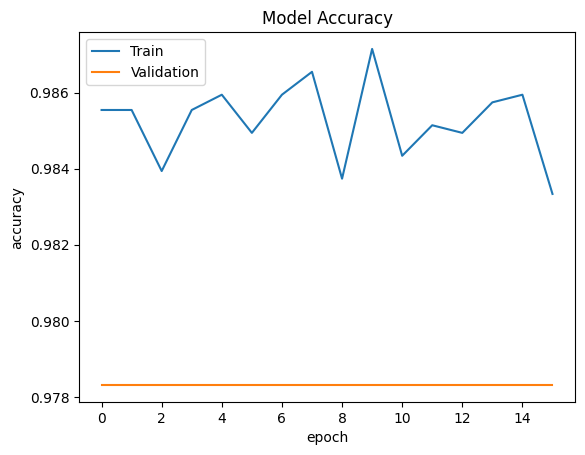

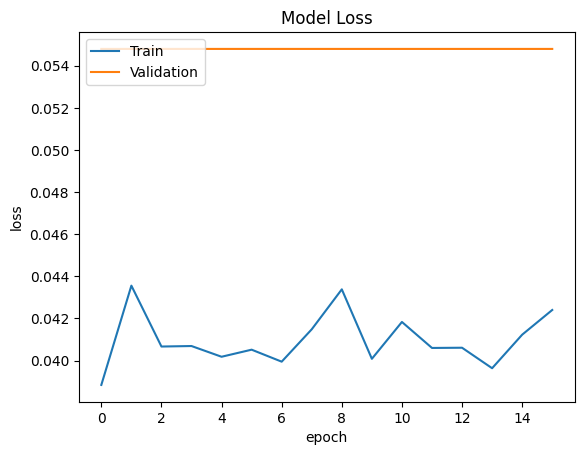

In [60]:
history(hist)

In [61]:
# EVALUATE TRAINING ACCURACY
results = model.evaluate(train_ds)

156/156 [==============================] - 4s 24ms/step - loss: 0.0339 - accuracy: 0.9886


In [62]:
# EVALUATE VALIDATION ACCURACY
results = model.evaluate(val_ds)

39/39 [==============================] - 1s 24ms/step - loss: 0.0548 - accuracy: 0.9783


### Classification Report

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np 

prediction_classes = np.array([])
true_classes =  np.array([])

for x, y in val_ds:
  prediction_classes = np.concatenate([prediction_classes,
                       np.argmax(model.predict(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])
    
print(classification_report(true_classes, prediction_classes, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    cataract     0.9852    0.9708    0.9780       617
      normal     0.9717    0.9857    0.9787       628

    accuracy                         0.9783      1245
   macro avg     0.9785    0.9782    0.9783      1245
weighted avg     0.9784    0.9783    0.9783      1245



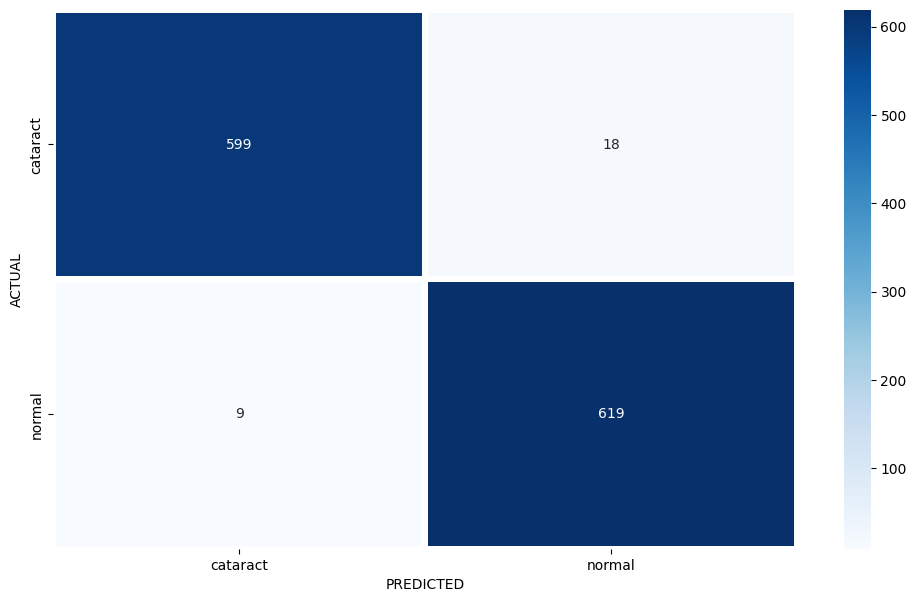

In [64]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
cm = confusion_matrix(true_classes, prediction_classes)

sns.heatmap(cm,cmap="Blues", annot=True,xticklabels=class_names, yticklabels=class_names ,linewidths=3 ,fmt='g')
plt.xlabel("PREDICTED")
plt.ylabel("ACTUAL")
plt.show()